# Using a Neural Network to predict wether it will Rain Tomorrow



In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.7
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
torch 1.5.0


In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data

Our dataset contains daily weather information from multiple Australian weather stations. We're about to answer a simple question. *Will it rain tomorrow?*

The data is hosted on [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) and created by [Joe Young](https://www.kaggle.com/jsphyg).

load it into a data frame:

In [2]:
df = pd.read_csv('./data/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


We have a large set of features/columns here. We also see some *NaN*s. Let's have a look at the overall dataset size:

In [3]:
df.shape

(142193, 24)

Looks like we have plenty of data. But we got to do something about those missing values.

## Data Preprocessing

We'll simplify the problem by removing most of the data. We'll use only 4 columns for predicting whether or not is going to rain tomorrow:

In [4]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Neural Networks don't work with much else than numbers. We'll convert *yes* and *no* to 1 and 0, respectively:

In [5]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

Let's drop the rows with missing values. There are better ways to do this, but we'll keep it simple:

In [6]:
df = df.dropna(how='any')
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0


Finally, we have a dataset we can work with. 

One important question we should answer is - *How balanced is our dataset?* Or *How many times did it rain or not rain tomorrow?*:

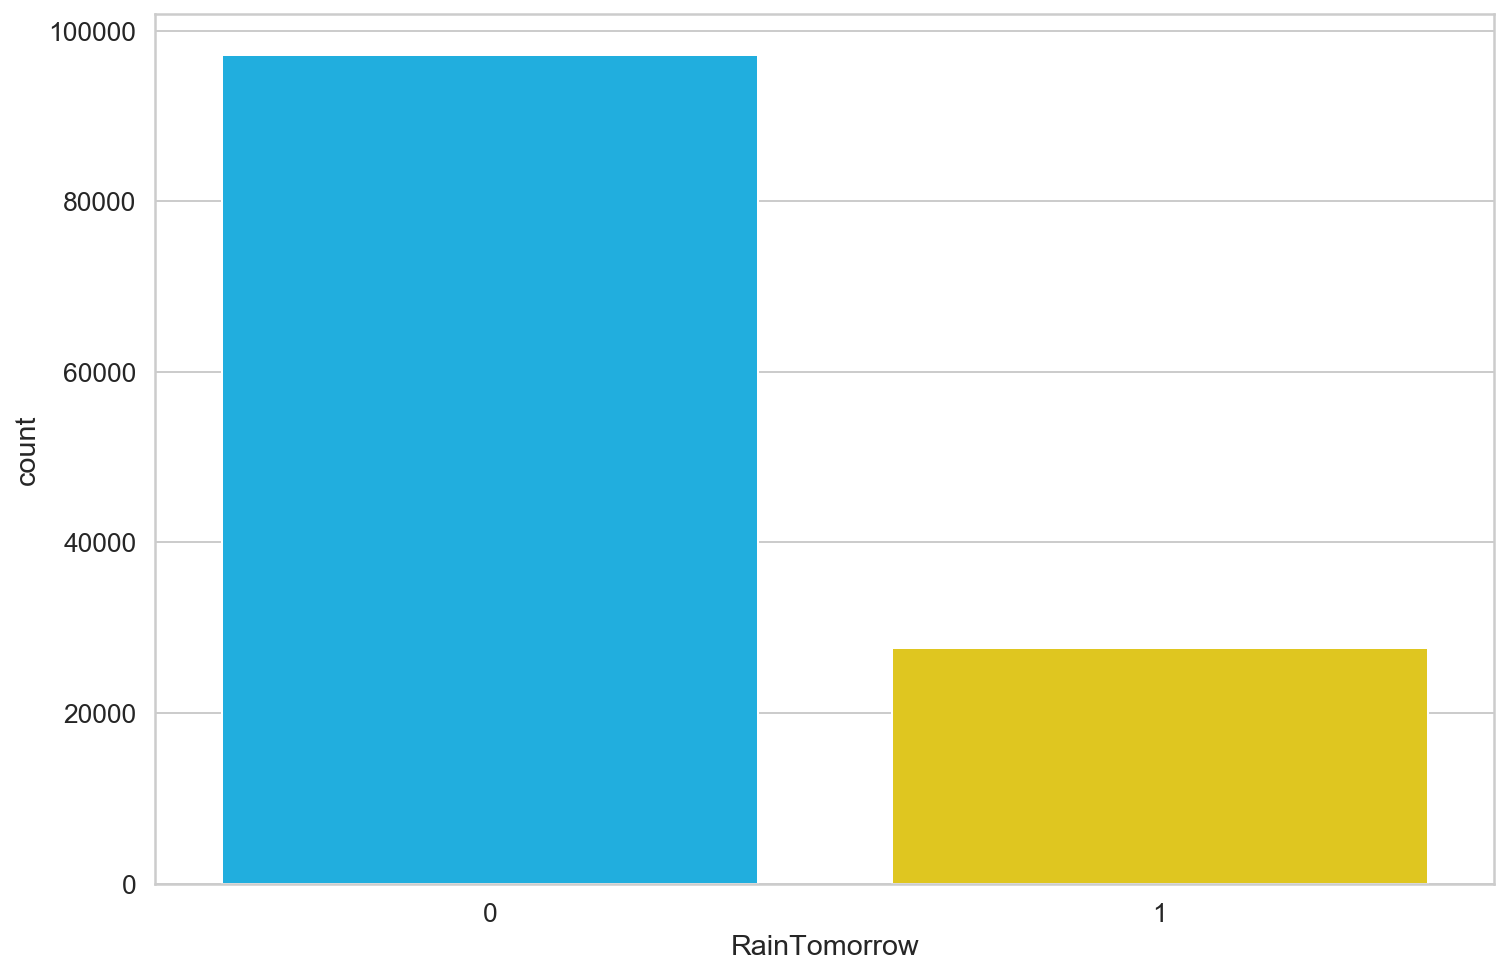

In [7]:
sns.countplot(df.RainTomorrow);

In [8]:
df.RainTomorrow.value_counts() / df.shape[0]

0    0.778762
1    0.221238
Name: RainTomorrow, dtype: float64

Things are not looking good. About 78% of the data points have a non-rainy day for tomorrow. This means that a model that predicts there will be no rain tomorrow will be correct about 78% of the time. Here, we'll just hope for the best.

The final step is to split the data into train and test sets:

In [9]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

And convert all of it to Tensors (so we can use it with PyTorch):

In [10]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


## Building a Neural Network

We'll build a simple Neural Network (NN) that tries to predicts will it rain tomorrow. 

Our input contains data from the four columns: `Rainfall, Humidity3pm, RainToday, Pressure9am`. We'll create an appropriate input layer for that.

The output will be a number between 0 and 1, representing how likely (our model thinks) it is going to rain tomorrow. The prediction will be given to us by the final (output) layer of the network. 

We'll add two (hidden) layers between the input and output layers. The parameters (neurons) of those layer will decide the final output. All layers will be fully-connected.


In [11]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

We start by creating the layers of our model in the constructor. The `forward()` method is where the magic happens. It accepts the input `x` and allows it to flow through each layer.

## Training

With the model in place, we need to find parameters that predict will it rain tomorrow. First, we need something to tell us how good we're currently doing:

In [12]:
criterion = nn.BCELoss()

The [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss) is a loss function that measures the difference between two binary vectors. In our case, the predictions of our model and the real values. It expects the values to be outputed by the sigmoid function. The closer this value gets to 0, the better your model should be.

But how do we find parameters that minimize the loss function?

### Optimization

Imagine that each parameter of our NN is a knob. The optimizer's job is to find the perfect positions for each knob so that the loss gets close to 0. 

Real-world models can contain millions or even billions of parameters. With so many knobs to turn, it would be nice to have an efficient optimizer that quickly finds solutions.

Contrary to what you might believe, optimization in Deep Learning is just satisfying. In practice, you're content with good enough parameter values that give you an acceptable accuracy.

While there are tons of optimizers you can choose from, [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) is a safe first choice. PyTorch has a well-debugged implementation you can use:

In [19]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

Naturally, the optimizer requires the parameters. The second argument `lr` is *learning rate*. It is a tradeoff between how good parameters you're going to find and how fast you'll get there. Finding good values for this can be black magic and a lot of brute-force "experimentation".

### Doing it on the GPU

Doing massively parallel computations on GPUs is one of the enablers for modern Deep Learning. You'll need nVIDIA GPU for that.

PyTorch makes it really easy to transfer all the computation to your GPU:

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [22]:
net = Net(4)
net = net.to(device)

criterion = criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.0001 ) 

We start by checking whether or not a CUDA device is available. Then, we transfer all training and test data to that device. Finally, we move our model and loss function.

### Weather Forecasting

Having a loss function is great, but tracking the accuracy of our model is something easier to understand, for us mere mortals. Here's the definition for our accuracy:

In [18]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

We convert every value below 0.5 to 0. Otherwise, we set it to 1. Finally, we calculate the percentage of correct values.

With all the pieces of the puzzle in place, we can start training our model:

In [23]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 0.94, accuracy: 0.779
Test  set - loss: 0.94, accuracy: 0.778

epoch 100
Train set - loss: 0.754, accuracy: 0.779
Test  set - loss: 0.754, accuracy: 0.778

epoch 200
Train set - loss: 0.625, accuracy: 0.779
Test  set - loss: 0.625, accuracy: 0.778

epoch 300
Train set - loss: 0.546, accuracy: 0.779
Test  set - loss: 0.545, accuracy: 0.778

epoch 400
Train set - loss: 0.503, accuracy: 0.779
Test  set - loss: 0.503, accuracy: 0.778

epoch 500
Train set - loss: 0.483, accuracy: 0.779
Test  set - loss: 0.483, accuracy: 0.779

epoch 600
Train set - loss: 0.474, accuracy: 0.779
Test  set - loss: 0.474, accuracy: 0.779

epoch 700
Train set - loss: 0.47, accuracy: 0.779
Test  set - loss: 0.47, accuracy: 0.779

epoch 800
Train set - loss: 0.468, accuracy: 0.78
Test  set - loss: 0.467, accuracy: 0.779

epoch 900
Train set - loss: 0.466, accuracy: 0.78
Test  set - loss: 0.466, accuracy: 0.779



## Saving the model

Training a good model can take a lot of time. And I mean weeks, months or even years. So, let's make sure that you know how you can save your precious work. Saving is easy:

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Restoring your model is easy too:

In [ ]:
net = torch.load(MODEL_PATH)

## Evaluation

Wouldn't it be perfect to know about all the errors your model can make? Of course, that's impossible. But you can get an estimate.

Using just accuracy wouldn't be a good way to do it. Recall that our data contains mostly no rain examples.

One way to delve a bit deeper into your model performance is to assess the precision and recall for each class. In our case, that will be *no rain* and *rain*:

In [24]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.78      1.00      0.88     19413
     Raining       0.82      0.01      0.01      5525

    accuracy                           0.78     24938
   macro avg       0.80      0.50      0.44     24938
weighted avg       0.79      0.78      0.68     24938



 A maximum precision of 1 indicates that the model is perfect at identifying only relevant examples. A maximum recall of 1 indicates that our model can find all relevant examples in the dataset for this class.

 You can see that our model is doing good when it comes to the *No rain* class. We have so many examples. Unfortunately, we can't really trust predictions of the *Raining* class.

 One of the best things about binary classification is that you can have a good look at a simple confusion matrix:

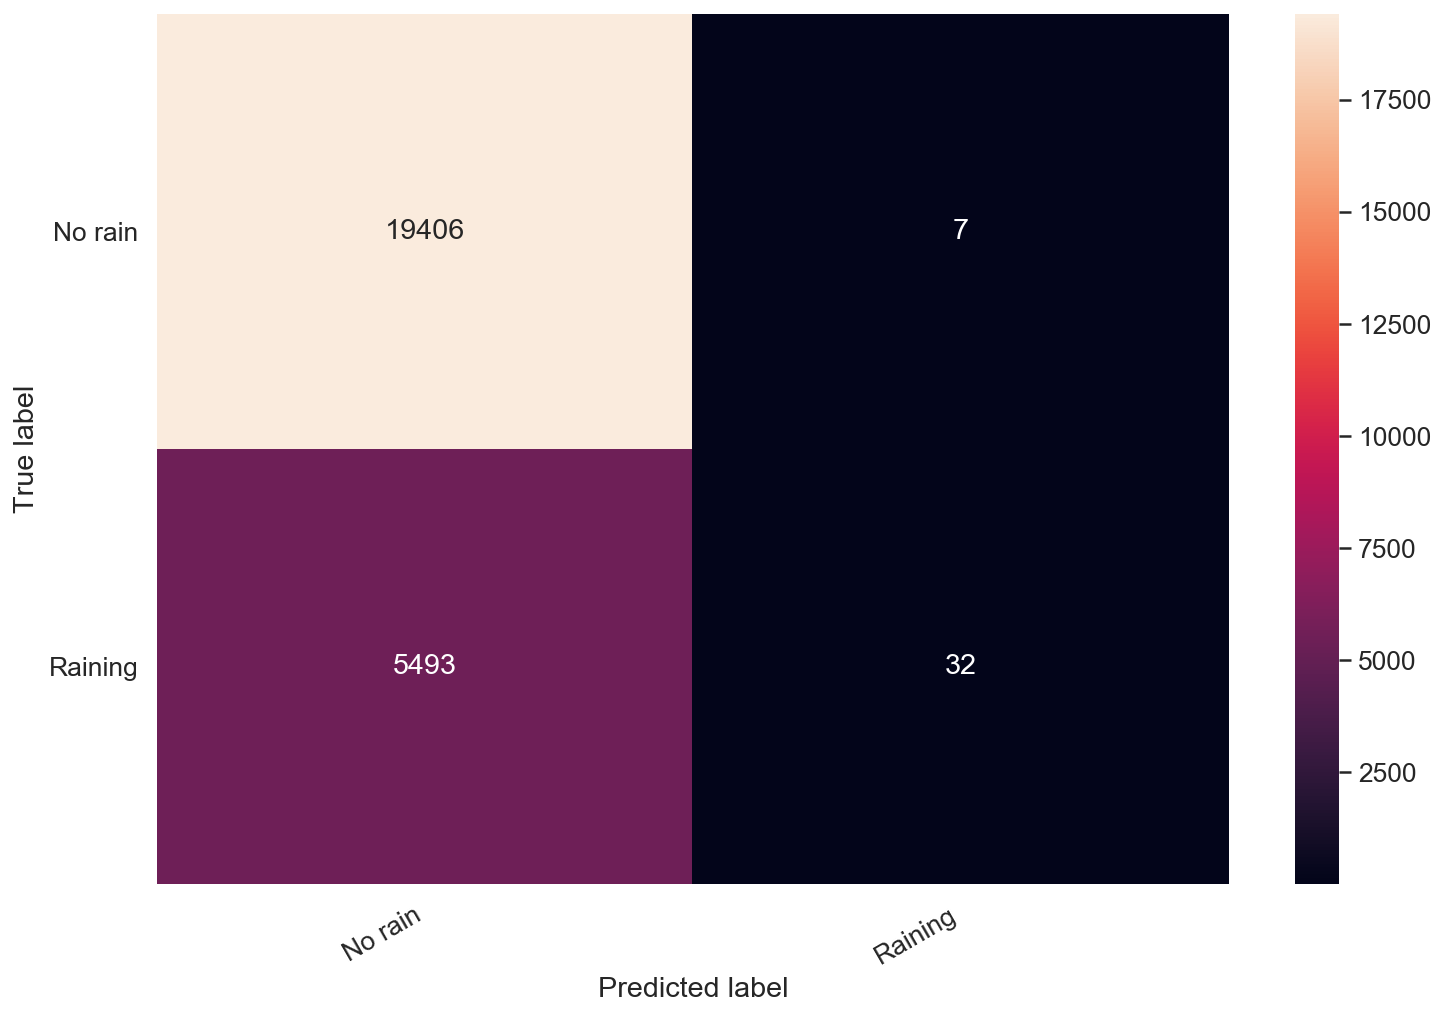

In [25]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

You can clearly see that our model shouldn't be trusted when it says it's going to rain.

## Making Predictions

Let's pick our model's brain and try it out on some hypothetical examples:

In [26]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

This little helper will return a binary response based on your model predictions. Let's try it out:

In [27]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True

In [28]:
will_it_rain(rainfall=0, humidity=1, rain_today=False, pressure=100)

True

Okay, we got two different responses based on some parameters (yep, the power of the brute force). Your model is ready for deployment (but please don't)!